### can run this one by one interactively or, as a batch, run `../scripts/general_postproc.py`

In [1]:
import sys
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
sys.path.insert(0,'../scripts/')
from postprocessing import setup_postproc, check_pdc, plot_phi, get_obs_and_noise, get_pars, plot_group, plot_pars_group

/Users/mnfienen/Documents/GIT/hytest/NHM_CAL/nhm_pestpp/notebooks/../dependencies/pyemu/pst/pst_handler.py:15: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


In [2]:
# curr_model = '01473000'
# curr_model = '05431486'
curr_model = '09112500'
curr_run_root = 'ies_hot'
# curr_run_root = 'prior_mc_reweight'
eval_pdc = False
unzip_dirs = True
phi_cutoffs = {cm:{crr:9e99 for crr in ['ies','prior_mc_reweight']}
                for cm in ['01473000','05431486', '09112500']}
pstdir, results_file, tmp_res_path, fig_dir, obs, pst = setup_postproc(curr_model, curr_run_root, unzip_dirs)

error parsing metadata from 'obsnme', continuing


### check out PDC

In [3]:
pst.nnz_obs_groups

['g_min_actet_mean_mon',
 'g_min_actet_mon',
 'g_min_recharge_ann',
 'g_min_runoff_mon',
 'g_min_soil_moist_ann',
 'g_min_soil_moist_mon',
 'l_max_actet_mean_mon',
 'l_max_actet_mon',
 'l_max_recharge_ann',
 'l_max_runoff_mon',
 'l_max_soil_moist_ann',
 'l_max_soil_moist_mon',
 'streamflow_daily_pulse_asc',
 'streamflow_daily_pulse_dsc',
 'streamflow_daily_low',
 'streamflow_daily_exlow',
 'streamflow_mean_mon',
 'streamflow_mon']

In [4]:
if eval_pdc:
    pdc = check_pdc(tmp_res_path, curr_run_root, pst, obs)
    print(pdc)

### look at PHI history

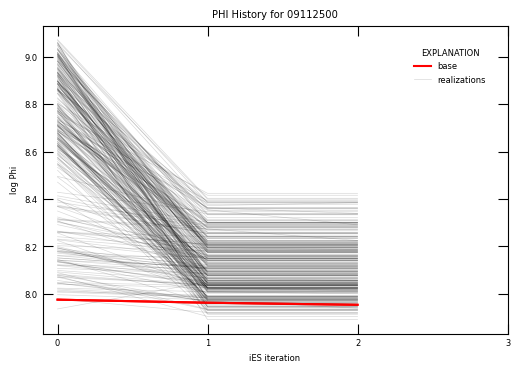

In [5]:
phi = plot_phi(tmp_res_path, curr_run_root, curr_model, fig_dir)

### Truncate PHI at a threshold

In [6]:
phi

,total_runs,mean,standard_deviation,min,max,0,1,2,3,4,...,306,307,308,309,310,311,312,313,314,base
iteration,,,,,,,,,,,,,,,,,,,,,
0,0,555339000.0,305553000.0,86280700.0,1.182450e+09,552779000.0,141662000.0,919581000.0,628410000.0,772259000.0,...,424024000.0,481789000.0,635778000.0,170117000.0,597927000.0,490766000.0,233402000.0,432332000.0,878596000.0,94425600.0
1,466,138649000.0,41988300.0,77799400.0,2.653820e+08,191519000.0,128562000.0,105996000.0,105022000.0,122421000.0,...,102128000.0,93921600.0,260402000.0,151441000.0,230523000.0,241650000.0,139728000.0,92871500.0,NaN,91635400.0
2,626,138411000.0,41772000.0,77799400.0,2.653820e+08,191519000.0,128562000.0,103101000.0,105022000.0,122421000.0,...,102128000.0,93921600.0,260402000.0,151441000.0,218278000.0,241650000.0,139728000.0,92871500.0,NaN,89816500.0


In [7]:
best_iter = 2
if 'prior' in curr_run_root:
    best_iter = 0
best_iter

2

## now rejection sampling for outlier PHI values

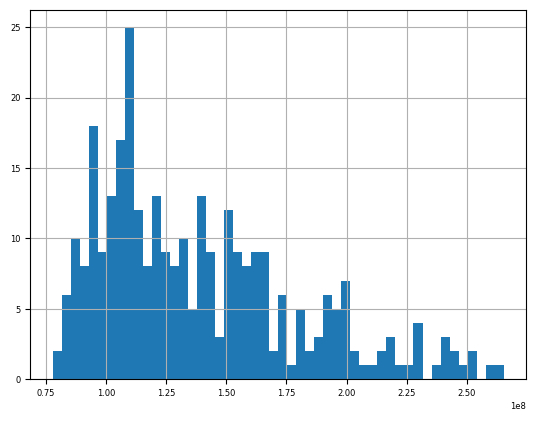

In [8]:
orgphi = phi.loc[best_iter].iloc[5:].copy()
ax = orgphi.hist(bins=50)
lims = ax.get_xlim()

In [9]:
# catalog of cutoffs heuristically determined
phi_cutoffs['01473000']['prior_mc_reweight'] = .6e10
phi_cutoffs['01473000']['ies_hot'] = 1.5e7
phi_cutoffs['05431486']['prior_mc_reweight'] = 2.2e9
phi_cutoffs['05431486']['ies_hot'] = 1.4e8
phi_cutoffs['09112500']['prior_mc_reweight'] = 3.0e9
phi_cutoffs['09112500']['ies_hot'] = 1.5e8

In [10]:
phi_too_high = phi_cutoffs[curr_model][curr_run_root]
phi_too_high

150000000.0

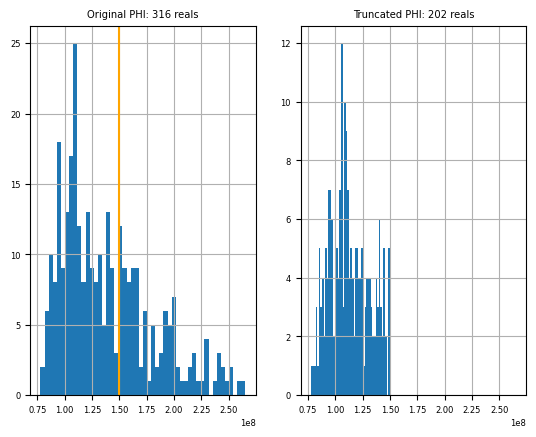

In [11]:
phi = orgphi.loc[orgphi<=phi_too_high]
fig,ax = plt.subplots(1,2)
### --> need to indicate which reals we will carry forward <-- ###
orgphi.hist(bins=50, ax=ax[0])
reals = phi.index 
phi.hist(bins=50, ax=ax[1])
ax[0].axvline(phi_too_high, color='orange')
ax[1].set_xlim(lims)
ax[0].set_title(f'Original PHI: {len(orgphi)} reals')
ax[1].set_title(f'Truncated PHI: {len(phi)} reals')
plt.savefig(fig_dir/ 'phi_histogram.pdf')


# How about parameters?

In [12]:
parens = get_pars(tmp_res_path, curr_run_root, reals, best_iter, pst)


In [13]:
pargps = parens['pargroup'].unique()
pargps


array(['adjmix_rain', 'carea_max', 'cecn_coef', 'emis_noppt',
       'fastcoef_lin', 'freeh2o_cap', 'gwflow_coef', 'jh_coef', 'mann_n',
       'potet_sublim', 'rad_trncf', 'radmax', 'rain_cbh_adj',
       'slowcoef_sq', 'smidx_coef', 'smidx_exp', 'snarea_thresh',
       'snow_cbh_adj', 'snowinfil_max', 'soil2gw_max', 'soil_moist_max',
       'soil_rechr_max_frac', 'ssr2gw_exp', 'ssr2gw_rate',
       'tmax_allrain_offset', 'tmax_allsnow', 'tmax_cbh_adj',
       'tmin_cbh_adj'], dtype=object)

evaluating parameter group: adjmix_rain
plotting parameter group: adjmix_rain
evaluating parameter group: carea_max
plotting parameter group: carea_max


AttributeError: 'NoneType' object has no attribute 'savefig'

<Figure size 640x480 with 0 Axes>

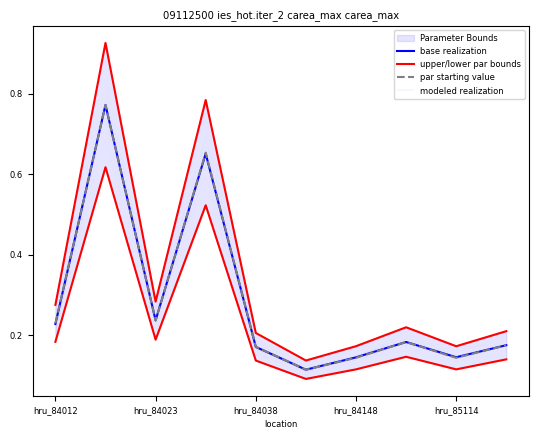

In [14]:
for cg in pargps:
    plot_pars_group(parens, cg, fig_dir, curr_model, best_iter, curr_run_root)

# Now let's start looking at the fits

In [15]:
modens, obens_noise = get_obs_and_noise(tmp_res_path, curr_run_root, reals, best_iter)

In [16]:
modens

,g_min_actet_mean_mon:10:84012,g_min_actet_mean_mon:10:84017,g_min_actet_mean_mon:10:84023,g_min_actet_mean_mon:10:84032,g_min_actet_mean_mon:10:84038,g_min_actet_mean_mon:10:84124,g_min_actet_mean_mon:10:84148,g_min_actet_mean_mon:10:84165,g_min_actet_mean_mon:10:85114,g_min_actet_mean_mon:10:85116,...,streamflow_mon:2010_5:09112200,streamflow_mon:2010_5:09112500,streamflow_mon:2010_6:09112200,streamflow_mon:2010_6:09112500,streamflow_mon:2010_7:09112200,streamflow_mon:2010_7:09112500,streamflow_mon:2010_8:09112200,streamflow_mon:2010_8:09112500,streamflow_mon:2010_9:09112200,streamflow_mon:2010_9:09112500
1,0.054608,0.019754,0.034746,0.011048,0.052860,0.085507,0.064025,0.054004,0.059493,0.050835,...,38.11630,321.183,25.83300,219.860,17.83070,151.698,12.45020,106.1270,8.31463,70.6095
2,0.042956,0.013905,0.047475,0.027887,0.046917,0.088518,0.088810,0.060779,0.065267,0.055393,...,21.23950,346.521,15.17630,244.605,10.51000,172.460,7.23529,120.7600,4.99360,84.3104
3,0.043528,0.012860,0.068387,0.022631,0.061671,0.054120,0.066377,0.068004,0.086656,0.047896,...,42.89330,462.143,31.16650,311.161,20.04960,202.128,12.81150,131.9260,8.23092,84.6150
4,0.048242,0.015354,0.047825,0.016072,0.061574,0.048806,0.069588,0.068257,0.070310,0.038910,...,58.06130,347.051,40.12660,226.659,27.64140,152.462,18.92270,103.2290,13.01140,69.3755
5,0.042667,0.011443,0.038209,0.025850,0.056628,0.048921,0.071774,0.054595,0.080755,0.047051,...,58.01930,477.402,42.23370,323.090,30.43560,212.809,21.79880,139.9940,15.68790,90.8168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,0.041518,0.010927,0.042892,0.022800,0.051657,0.053689,0.062916,0.043074,0.072128,0.052876,...,42.43360,355.255,29.44880,242.140,20.14640,163.556,13.70420,110.3620,9.35695,72.4400
313,0.052815,0.005883,0.049282,0.018746,0.048607,0.071831,0.080620,0.072333,0.078105,0.042675,...,53.87050,374.958,37.51850,267.287,26.13090,187.456,18.09220,130.5240,12.56740,89.7912
base,0.048330,0.012054,0.049628,0.018612,0.050607,0.066270,0.074192,0.061271,0.075086,0.051097,...,34.44730,298.172,23.65980,204.056,16.27080,139.744,11.12360,95.5262,7.63191,64.2850
mod_min,0.025852,0.005883,0.027065,0.009492,0.030569,0.037537,0.040248,0.036197,0.048084,0.033581,...,9.59051,233.355,6.16962,150.883,5.12854,101.020,3.60144,69.6916,2.18250,43.1420


In [24]:
import numpy as np
modens.quantile([0.05,0.95])

,g_min_actet_mean_mon:10:84012,g_min_actet_mean_mon:10:84017,g_min_actet_mean_mon:10:84023,g_min_actet_mean_mon:10:84032,g_min_actet_mean_mon:10:84038,g_min_actet_mean_mon:10:84124,g_min_actet_mean_mon:10:84148,g_min_actet_mean_mon:10:84165,g_min_actet_mean_mon:10:85114,g_min_actet_mean_mon:10:85116,...,streamflow_mon:2010_5:09112200,streamflow_mon:2010_5:09112500,streamflow_mon:2010_6:09112200,streamflow_mon:2010_6:09112500,streamflow_mon:2010_7:09112200,streamflow_mon:2010_7:09112500,streamflow_mon:2010_8:09112200,streamflow_mon:2010_8:09112500,streamflow_mon:2010_9:09112200,streamflow_mon:2010_9:09112500
0.05,0.033601,0.008329,0.034581,0.011906,0.037943,0.044969,0.051723,0.046143,0.056975,0.039640,...,17.47188,287.59490,11.870895,194.33550,8.176910,133.03485,5.699441,90.776235,3.66449,59.698005
0.95,0.067692,0.023440,0.067546,0.029905,0.064502,0.085475,0.092600,0.076769,0.086324,0.061649,...,72.98104,469.63235,50.127095,320.87615,34.423655,213.75985,23.469090,146.448250,16.11357,97.934640


In [ ]:
obens_noise

In [ ]:
pst.obs_groups

In [ ]:
# plot_group('sca_daily', obs, modens, obens_noise, fig_dir, curr_model)

In [ ]:
plot_group('actet_mean_mon', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)
plot_group('actet_mon', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)
plot_group('runoff_mon', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)
plot_group('soil_moist_mon', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)
plot_group('recharge_ann', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)

# streamflow_daily is a special case - all aggregated
plot_group('streamflow_daily', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)
plot_group('streamflow_mean_mon', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)
plot_group('streamflow_mon', obs, modens, obens_noise, fig_dir, curr_model, best_iter, curr_run_root)
